
This notebook uses the outputs
--- workflow/rules/20_preprocessing::prep_t2t_seq_class_cache_file
--- data/sample_phylo_order.tsv
--- fasta_index_files (55_subset_wg::extract_chrom_contigs (+.fai))
as input, and produces the assembly contiguity heatmap for figure 1.

Repository directory:  /home/local/work/code/github/project-male-assembly
Execution directory:  /home/local/work/code/github/project-male-assembly/notebooks/plotting/contig_heatmap
Working directory:  /home/local/work/data/sig_chrY/paper
Output directory:  /home/local/work/data/sig_chrY/paper/output/figures


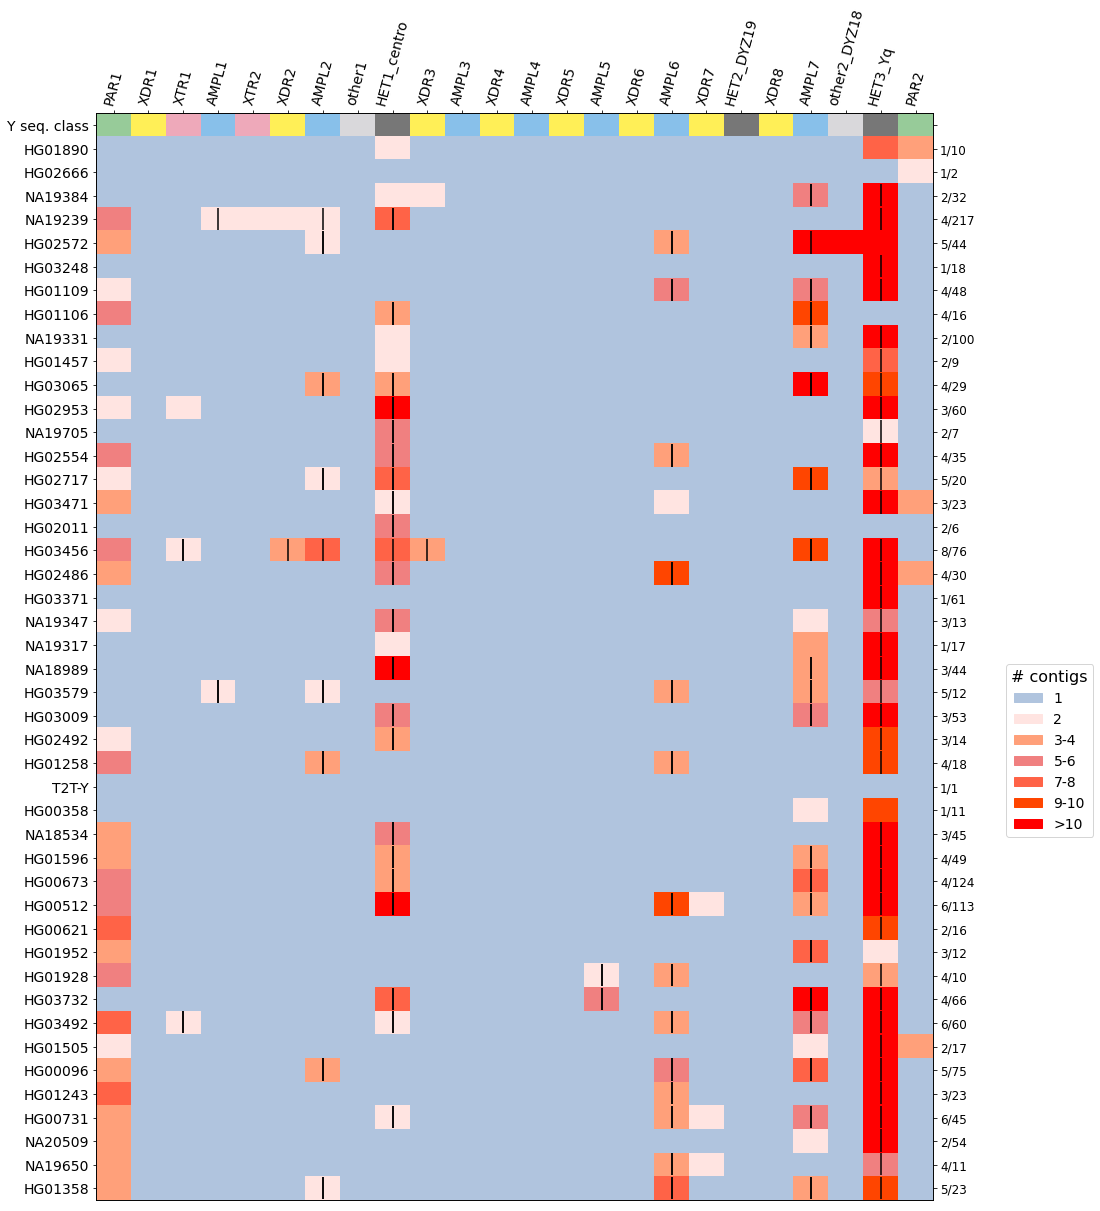

In [26]:
import pathlib as pl

import pandas as pd
import numpy as np
import collections as collect

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.patches as mpt

desc="""
This notebook uses the outputs
--- workflow/rules/20_preprocessing::prep_t2t_seq_class_cache_file
--- data/sample_phylo_order.tsv
--- fasta_index_files (55_subset_wg::extract_chrom_contigs (+.fai))
as input, and produces the assembly contiguity heatmap for figure 1.
"""

print(desc)

repo_dir = pl.Path('/home/local/work/code/github/project-male-assembly').resolve(strict=True)
exec_dir = pl.Path('.').resolve(strict=True)
wd_dir = pl.Path('/home/local/work/data/sig_chrY/paper').resolve(strict=True)
out_dir = pl.Path('/home/local/work/data/sig_chrY/paper/output/figures').resolve(strict=True)

print('Repository directory: ', repo_dir)
print('Execution directory: ', exec_dir)
print('Working directory: ', wd_dir)
print('Output directory: ', out_dir)
print('=================================')

drop_samples = [
    'HG02666',
    'NA19384',
    'HG01457',
    'NA18989',
    'NA24385'
]

seq_classes_t2t_file = wd_dir / pl.Path('annotation_tables', 'T2T.chrY-seq-classes.tsv')
sqcls_t2t = pd.read_csv(seq_classes_t2t_file, header=0, sep='\t')

# The sample order in the phylogenetic tree starts at 1 (biologists...),
# which is fitting here because at row index 0, the sequence classes
# should be plotted. Additionally, the T2T sample is included in the sample
# order at position 28.
phylo_order_file = repo_dir / pl.Path('data', 'sample_phylo_order.tsv')
phylo_order = pd.read_csv(phylo_order_file, sep='\t', header=0)
phylo_order.sort_values('order_top', ascending=True, inplace=True)
phylo_order = phylo_order.loc[~phylo_order['sample'].isin(drop_samples), :].copy()

# 44 samples plus sequence classes at top plus T2T-Y in the middle
plot_data = np.ones((phylo_order.shape[0] + 1, sqcls_t2t.shape[0], 3), dtype=np.float32)
assert plot_data.shape[0] == 46

name_col_idx_map = dict()
seq_class_names = []

row_idx = 0
red, green, blue = 0, 1, 2
for row in sqcls_t2t.itertuples(index=True):
    plot_data[row_idx, row.Index, red] = row.red
    plot_data[row_idx, row.Index, green] = row.green
    plot_data[row_idx, row.Index, blue] = row.blue
    name_col_idx_map[row.name] = row.Index
    seq_class_names.append(row.name)


fasta_index_files = list((wd_dir / pl.Path('fasta_idx')).glob('*.fai'))
count_contigs = np.zeros((phylo_order.shape[0], sqcls_t2t.shape[0]), dtype=np.int16)
assert (plot_data.shape[0] - 1) == count_contigs.shape[0]

samples = ['Y seq. class']
breaklines_x = []
breaklines_y = []
right_y_ticklabels = ['']

for row in phylo_order.itertuples():
    if row.sample in drop_samples:
        continue
    row_idx = row.order_top - 1  # top to bottom layout order in tree
    sample = row.sample
    if row_idx == 27:
        assert sample == 'T2T-Y'
        samples.append(sample)
        count_contigs[row_idx, :] += 1
        right_y_ticklabels.append('1/1')
        continue
    fasta_index_file = [f for f in fasta_index_files if sample in f.stem]
    
    assert len(fasta_index_file) == 1, fasta_index_file
    fasta_index_file = fasta_index_file[0]
    if sample.startswith('HC'):
        if sample in ['HC02666', 'HC01457']:
            sample = sample.replace('HC', 'HG')
        else:
            sample = sample.replace('HC', 'NA')
    samples.append(sample)
    with open(fasta_index_file, 'r') as faidx:
        contigs = [line.split()[:2] for line in faidx.readlines()]
        contigs = sorted([(n, int(l)) for n, l in contigs], reverse=False)
        
    total_contigs = len(contigs)
    considered_contigs = 0
    last_spanned_regions = 0
    non_contiguous_assemblies = set()
    nca = non_contiguous_assemblies  # shorthand
    for num, (contig, contig_size) in enumerate(contigs, start=1):
        from_class, to_class = contig.split('.')[3].split('-')
        from_col = name_col_idx_map[from_class]
        to_col = name_col_idx_map[to_class]
        is_ctg_assm = (to_col - from_col) > 1
        if is_ctg_assm:
            if from_col != 0:  # PAR1
                breaklines_x.append(from_col)
                breaklines_y.append(row_idx + 1 - 0.5)
            nca.add(from_col)
            if to_col != 23:  # PAR2
                breaklines_x.append(to_col)
                breaklines_y.append(row_idx + 1 - 0.5)
            nca.add(to_col)
        # plus 1 for column here to make inclusive
        count_contigs[row_idx, from_col:to_col+1] += 1
        spanned_regions = (count_contigs[row_idx, :] > 0).sum()
        # next: correct for unclear definition of "contiguously assembled"
        # for PAR1 and PAR2
        if last_spanned_regions < sqcls_t2t.shape[0] - 2:
            if spanned_regions > last_spanned_regions:
                considered_contigs += 1
                last_spanned_regions = spanned_regions

        contig_spans.append((num, (count_contigs[row_idx, :] > 0).sum()))
    right_y_ticklabels.append(f'{considered_contigs}/{total_contigs}')

color_map = collect.OrderedDict({
    1: 'lightsteelblue',
    2: 'mistyrose',
    3: 'lightsalmon',
    4: 'lightsalmon',
    5: 'lightcoral',
    6: 'lightcoral',
    7: 'tomato',
    8: 'tomato',
    9: 'orangered',
    10: 'orangered'
})
    
for row in range(45):
    for col in range(sqcls_t2t.shape[0]):
        ctg_count = count_contigs[row, col]
#         r, g, b, a = cm.gist_heat(ctg_count)
        count_color = color_map.get(ctg_count, 'red')
        r, g, b, a = colors.to_rgba(count_color)
        plot_data[row+1, col, red] = r
        plot_data[row+1, col, green] = g
        plot_data[row+1, col, blue] = b

fig, ax = plt.subplots(figsize=(15,20))
_ = ax.imshow(plot_data, aspect='auto')
_ = ax.set_yticks(np.arange(plot_data.shape[0]))
_ = ax.set_yticklabels(samples, fontsize=14)

ax2 = ax.twinx()
_ = ax2.set_yticks(np.arange(plot_data.shape[0]))
_ = ax2.set_yticklabels(right_y_ticklabels, fontsize=12)
_ = ax2.yaxis.tick_right()
ax2.set_ylim(ax.get_ylim())

_ = ax.set_xticks(np.arange(len(seq_class_names)))
_ = ax.set_xticklabels(seq_class_names, fontsize=14, rotation=75)
_ = ax.xaxis.tick_top()

_ = ax.vlines(
    breaklines_x,
    breaklines_y,
    np.array(breaklines_y, dtype=np.float16) + 0.95,
    colors='black'
)



legend = []

for k, v in color_map.items():
    if k % 2 == 0 and k > 2:
        continue
    if k < 3:
        label=f'{k}'
    else:
        label=f'{k}-{k+1}'
    legend.append(
        mpt.Patch(
            facecolor=v,
            edgecolor=v,
            label=label
        )
    )

legend.append(
    mpt.Patch(
        facecolor='red',
        edgecolor='red',
        label='>10'
    )
)
    
fig_legend = ax.legend(
    handles=legend,
    bbox_to_anchor=(1.2, 0.5),
    title='# contigs',
    fontsize=14
)
fig_legend.get_title().set_fontsize(16)

plt.savefig(
    out_dir / pl.Path('fig1_contig_heatmap.pdf'),
    bbox_inches='tight',
    bbox_extra_artists=[fig_legend]
)
plt.savefig(
    out_dir / pl.Path('fig1_contig_heatmap.png'),
    bbox_inches='tight',
    bbox_extra_artists=[fig_legend],
    dpi=150
)